## Генератор случайных чисел

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

О подходах к понятию случайности: 
Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

В основе стандартных ГСЧ лежит **алгоритм**. Как следствие, получаем детерминированную последовательность. Примеры алгоримтов https://en.wikipedia.org/wiki/List_of_random_number_generators.

"Настоящие" ГСЧ используют источники случайности, например https://www.random.org/.

## Генерация равномерного распределения

Для генерации равномерного распределения часто используют Linear congruential generator (LCG). Например, вызов```rand()``` в C/C++.

Алгоритм LCG генерирует последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Значение $z_0$ называется *seed*, стартуя с одного и того же $z_0$, будем получать одну и ту же последовательность чисел.

Пример LCG:

In [1]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Создадим последовательность из 10 элементов:

In [2]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

Параметры $m$, $a$ и $c$ нужно выбирать аккуратно. Случайный выбор констант может привести к неожиданным результатам:

In [3]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Гистограмма похожа на равномерное распределение

In [4]:
import matplotlib.pyplot as plt
plt.hist(random, density=True)
plt.show()

<Figure size 640x480 with 1 Axes>

Но вот что происходит в 2D. Точки явно не расположены случайно:

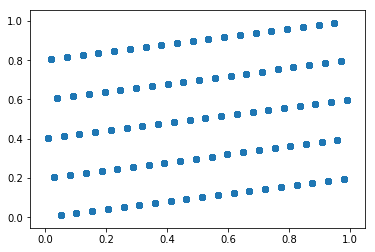

In [5]:
plt.scatter(random[1:], random[:-1])
plt.show()

Более удачный выбор констант хорошо распределяет точки:

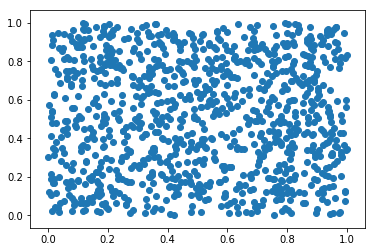

In [6]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

Примеры других тестов на случайность: [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

## Моделирование распределений

Как с помощью генератора равномерного распределеия на (0, 1) моделировать выборку из распределеия $F$?

### Inverse transform method

В основе *inverse transform method* лежит следующее набюдение:  если $\xi$ равномерна на $[0,1]$, тогда величина $F^{-1}(\xi)$ распределена по закону $F$. 

Докажите это утверждение. Для каких $F$ оно верно?

### Задача
Смоделировать выборку размера 1000 из распределения $Exp(\lambda)$ методом inverse transform. Нарисуйте выборочную гистограмму и истинную плотность распределения.

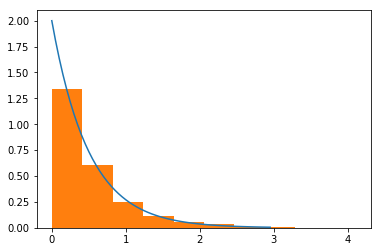

In [8]:
import numpy as np
import matplotlib.pyplot as plt

parametr = 2
exp = - np.log((np.random.uniform(0, 1, 1000)))/parametr
t = np.arange(0, 3, 0.05)

plt.plot(t, parametr * np.exp(-parametr * t))
plt.hist(exp, density = True)
plt.show()

### Rejection sampling (Accept-reject method)

Идея метода: моделировать выборку из распределения, для которого это умеем делать, и отбирать точки, которые попали под график целевого распределения.
![img](https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png)



### Задача
Строго обоснуйте метод rejection sampling. Смоделируйте выборку размера 100 из распределения, заданного ниже, используя генератор равномерного распределения.

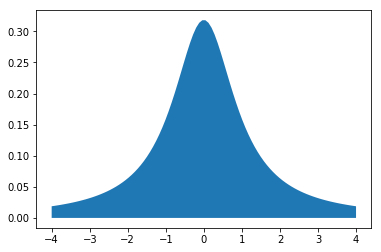

In [9]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

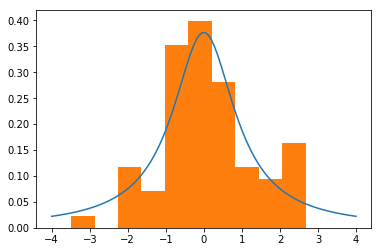

In [18]:
from scipy import integrate

norm, err = integrate.quad(lambda x: dist.pdf(x), -4, 4)
plt.plot(x, dist.pdf(x)/norm)
_max = dist.pdf(x).max()/norm
a1 = np.random.uniform(-4, 4, 100)
a2 = a1[np.random.uniform(0, _max, 100) < dist.pdf(a1)/norm]
a3 = a2
m = a2.size
for m in range(100):
    _x = np.random.uniform(-4, 4)
    if (np.random.uniform(0, _max) < dist.pdf(_x)/norm):
        a3 = np.append(a3, _x)
        m += 1
plt.hist(a3, density = True)
plt.show()

##  Coordinate transformation

### Задача
Смоделируйте выбору размера 100, равномерно распределенную внутри заданного треугольника. Для этого моделируйте точки внутри единичного квадрата и с помощию подходящего преобразования координат, переведите их внутрь треугольника. Нанесите полученную выборку на рисунок.

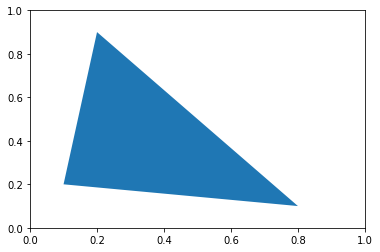

In [19]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

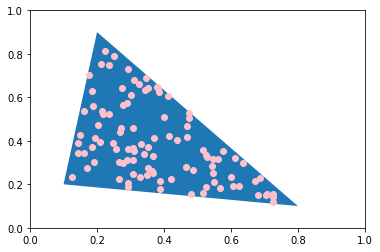

In [20]:
u = np.random.uniform(0, 1, 200)
unf = np.random.uniform(0, 1, 200)

x = u[unf < 1 - u]
n = x.size
y = unf[unf < 1 - u]

for n in range(100):
    z = np.random.uniform(0, 1)
    w = np.random.uniform(0, 1)
    if (w < 1 - z):
        x = np.append(x, z)
        y = np.append(y, w)
        n += 1

x1 = 0.7 * x + 0.1 * y + 0.1    #needed linear 
y1 = -0.1 * x + 0.7 * y + 0.2   #transformation

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))

plt.scatter(x1[:100], y1[:100], color = 'pink')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

### Задача
Смоделируйте выборку размера 500, равномерно распределенную внутри единичной окружности, не используя метод отбора. Нанесите полученную выборку на рисунок.

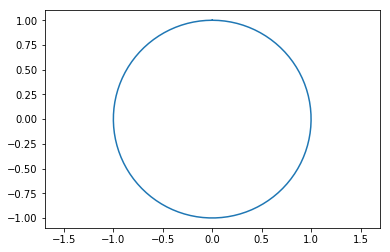

In [21]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

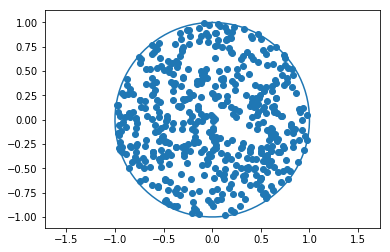

In [22]:
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')

phi = np.random.uniform(0, 2 * np.pi, 500)
r = np.sqrt(np.random.uniform(0, 1, 500))

x = np.cos(phi) * r
y = np.sin(phi) * r

plt.scatter(x, y)
plt.show()

## Random normal generator

### Задача

Докажите, что приведенный ниже алгоритм моделирует пары независимых N(0,1) величин. Преобразуйте алгоритм, чтобы исключить обращение к функциям ```np.sin``` и ```np.cos```.

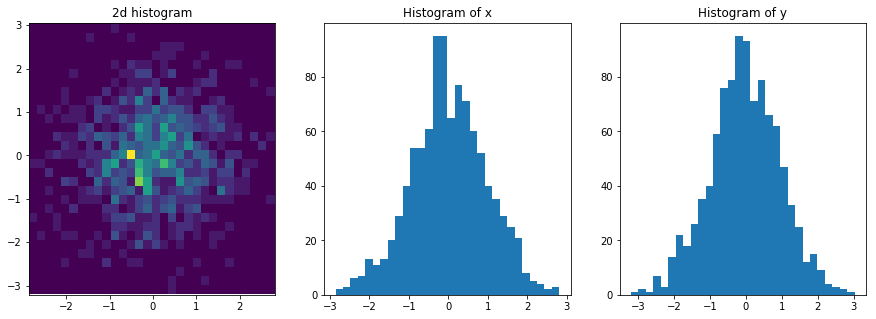

In [23]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

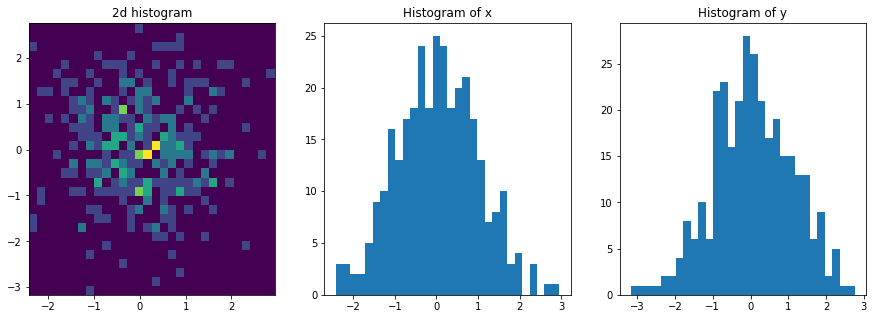

In [24]:
u1, u2 = (np.random.rand(2, 400)-0.5)*2
sum = u1*u1 + u2*u2
x=[]
y=[]
for i in range(400):
    if (sum[i]!=0) and (sum[i]<1):
        x.append(u1[i] * np.sqrt(-2*np.log(sum[i])/sum[i]))
        y.append(u2[i] * np.sqrt(-2*np.log(sum[i])/sum[i]))
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

## Markov Chain Monte Carlo (MCMC)

Алгоритм приближенного моделирование случаных величин из заданного распредедения. 

Идея:
* построить эргодическую цепь Маркова, для которой стационарное распределение - это в точности наше заданное распределение

* инициировать блуждание по цепи Маркова из некоторого начального состояния и дождаться, когда распределение сойдется в стационарному. С этого момента состояния цепи Маркова можно считать выборкой из желаемого распределения.

Вот как это работает https://chi-feng.github.io/mcmc-demo/app.html#RandomWalkMH,multimodal

Алгоритм:
* пусть $\pi$ - заданное распределение (не обязательно нормированное к 1) на множестве $\Omega$, из которохо хотим моделировать выборку
* пусть $Q = (q_{i,j})$ - матрица переходных вероятностей (переходная плотность) произвольной цепи Маркова с состояниями из $\Omega$
* выберем произвольное $X_0$ из $\Omega$
* для текущего $X_n$ смоделируем значение $Z_{n+1}$ из распределения $q_{X_n, \cdot}$
* смоделируем случайную величину $\alpha$ из распределения Бернулли с вероятностью успеха
$$
p = \min ( 1, \frac{\pi_j q_{j,i}}{\pi_i q_{i,j}} )
$$
* если $\alpha$ = 1, то $X_{n+1} = Z_{n+1}$, иначе $X_{n+1} = X_{n}$.

Обоснование метода можно почитать здесь http://probability.ca/jeff/ftpdir/johannes.pdf

Некоторые способы задания $q$:
* Metropolis algorithm: $q_{i,j} = q_{j,i}$
* Random walk Metropolis-Hastings: $q_{i,j} = q(j - i)$

В качетве примера рассмотрим выборку из модели $x|\mu \sim N(x;\mu,1)$, зададим априорное распределение параметров в виде  $\mu \sim N(0,1)$, и решим задачу нахождения апостериорного распределения параметров.

Задание выборки размера 20 для истинного значения $\mu=0$:

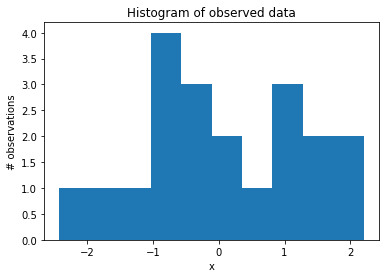

In [26]:
import numpy as np

np.random.seed(123)
data = np.random.randn(20)

plt.hist(data)
plt.title('Histogram of observed data')
plt.xlabel('x'), plt.ylabel('# observations')
plt.show()

Знание о сопряженных распределениях (https://en.wikipedia.org/wiki/Conjugate_prior) позволяет получить параметры апостериорного распределения аналитически:

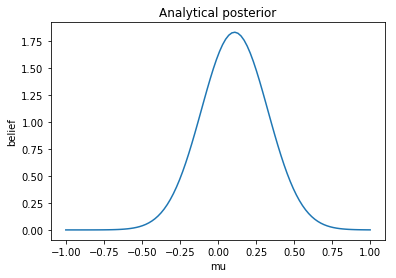

In [27]:
from scipy.stats import norm

mu_prior_mu = 0
mu_prior_sd = 1

def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 100)
posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
plt.plot(x, posterior_analytical)
plt.xlabel('mu'), plt.ylabel('belief'), plt.title('Analytical posterior')
plt.show()

Попробуем приблизиться к рассчитанному аналитически апостериорному распределению с помощью алгоритма МСМС. 

Зададим начальное состояние цепи Маркова:

In [28]:
mu_current = 1

Зададим переходную плотность в виде N(mu_current, proposal_width) и сделаем пробный шаг:

In [29]:
proposal_width = .1
mu_proposal = norm(mu_current, proposal_width).rvs()

Найдем отношение правбоподобий в текущей и пробной точке:

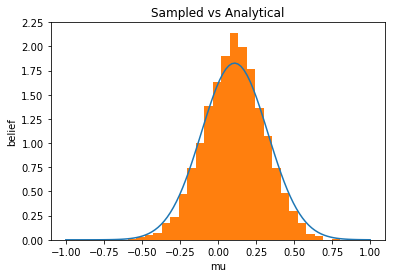

In [30]:
def mcmcsamp(data, k = 10000, mu_start = 5, proposal_width = .1, withrep = 0):
    
    mu_current = mu_start
    muarr1 = np.array([])
    muarr2 = np.array([])
    
    for i in range(k):
        mu_proposal = norm(mu_current, proposal_width).rvs()

        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal

        p_accept = min(1, p_proposal / p_current)

        accept = np.random.rand() < p_accept

        if accept:
            mu_current = mu_proposal
            muarr1 = np.append(muarr1, mu_current)
            
        muarr2 = np.append(muarr2, mu_current)
                
    if withrep:
        return muarr2
    else:
        return muarr1[(muarr1 >= - 1) & (muarr1 <= 1)][100:]
        
sample = mcmcsamp(data)
plt.plot(x, posterior_analytical)
plt.hist(sample, density = True, bins = 25)
plt.xlabel('mu'), plt.ylabel('belief')
plt.title('Sampled vs Analytical')
plt.show()

Определим параметр для вероятности перехода в пробную точку:

Моделируем случайную величину из распределения Бернулли и принимаем решение о переходе в пробную точку (или остаемся в текущем состоянии)

### Задача

Смоделируйте достаточное число переходов по цепи Маркова, после которого установится стационарное распределение, и сравните выборку из стационарного распределения с целевым распределением. Если теория не подведет, то выборочное распределение должно приближать целевое. Измените параметр ```proposal_width``` и проверьте как это влияет на скорость сходимости. Нарисуйте траекторию переходов по цепи Маркова для разных значений параметров.

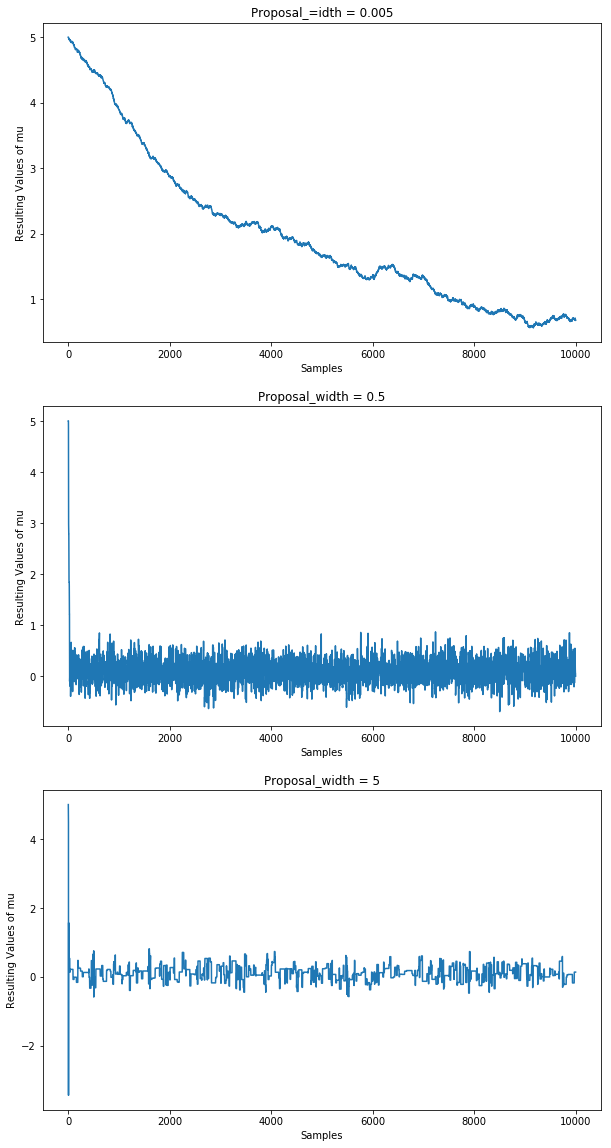

In [31]:
s1 = mcmcsamp(data, proposal_width = .005, withrep = 1)
s2 = mcmcsamp(data, proposal_width = .5, withrep = 1)
s3 = mcmcsamp(data, proposal_width = 5, withrep = 1)

plt.figure(1, figsize = (10, 20))

plt.subplot(311)
plt.plot(s1)
plt.xlabel('Samples'), plt.ylabel('Resulting Values of mu')
plt.title('Proposal_=idth = 0.005') 
plt.subplot(312)
plt.plot(s2)
plt.xlabel('Samples'), plt.ylabel('Resulting Values of mu')
plt.title('Proposal_width = 0.5') 
plt.subplot(313)
plt.plot(s3)
plt.xlabel('Samples'), plt.ylabel('Resulting Values of mu')
plt.title('Proposal_width = 5') 
plt.show()

### Submit to https://goo.gl/forms/aszSXdC53VV19kwx2